<a href="https://colab.research.google.com/github/kdwang1808/2020-MCM/blob/master/ABSA_Vader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
import sys
os.chdir('drive/Colab Notebooks/2020MCM_PC')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as tqdm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words("english")
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchsummary
!pip install vaderSentiment 
from vaderSentiment import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

####Lemmatization
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133kB 2.5MB/s 


In [0]:
hair = pd.read_csv("hair.csv")
micro = pd.read_csv("micro.csv")
baby = pd.read_csv("baby.csv")

In [65]:
hair.tail(30)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,review
9671,2015,8,28,72,4,0,0,"Buy this So far, an excellent hair dryer. Not ..."
9672,2015,8,28,217,5,0,0,Five Stars This item it's been working perfect...
9673,2015,8,28,239,5,0,0,Great little dryer! It is so hard to find a sm...
9674,2015,8,28,74,5,0,0,Perfect Perfect
9675,2015,8,28,11,5,0,0,Five Stars Great dryer.
9676,2015,8,29,72,5,0,0,Great Blow Dryer Live this hairdryer
9677,2015,8,29,319,5,0,0,Five Stars Perfect for travel.
9678,2015,8,29,278,5,0,0,Five Stars thanks
9679,2015,8,29,6,1,0,0,HOT AIR! I've had this blow dryer for just ove...
9680,2015,8,29,350,5,0,0,Works just like the ones in the hotels. So han...


In [0]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [0]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [0]:
import re
hair_clean=[]
for text in hair["review"]:
    hair_clean.append(clean_text(str(text)))
micro_clean=[]
for text in micro["review"]:
    micro_clean.append(clean_text(str(text)))
baby_clean=[]
for text in baby["review"]:
    baby_clean.append(clean_text(str(text)))

In [0]:
hair['clean'] = hair_clean
micro['clean'] = micro_clean
baby['clean'] = baby_clean

In [0]:
hair = hair.drop(["review"], axis=1)
baby = baby.drop(["review"], axis=1)
micro = micro.drop(["review"], axis=1)
hair.to_csv(r'hair_clean.csv', index = False)
baby.to_csv(r'baby_clean.csv', index = False)
micro.to_csv(r'micro_clean.csv', index = False)

In [71]:
baby.head(8)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean
0,2008,2,15,4383,5,1,2,womb sounds bear excellent newborn purchased w...
1,2008,3,16,1020,2,31,33,beware baby sucks everything loved look feel e...
2,2008,3,28,3846,3,0,6,get get hospital gave newborn take another pac...
3,2008,4,6,3349,5,0,0,wubbanuberiffic twin girls almost 2 months wub...
4,2008,6,5,4254,5,0,0,love pacifier daughter 3 5 mos old loves pacif...
5,2008,6,13,2325,3,0,0,weird taste smell sure got bad apple pacifier ...
6,2008,6,21,3846,1,0,2,cracked read reviews although cannot say bad p...
7,2008,6,23,1694,4,30,32,useful two bought husband one came home rehap ...


In [0]:
sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
  # text = str(text)
  return (sent_analyser.polarity_scores(text)["compound"])

In [76]:
hair["Polarity"] = hair["clean"].apply(sentiment)
hair.head(20)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity
0,2008,1,1,201,5,7,8,simply best blow dryer market best standard bl...,0.8555
1,2008,1,7,165,5,4,6,new best friend four year warranty try love ta...,0.9584
2,2008,1,8,75,5,16,17,terrific hair dryer caveat works great dryer u...,0.9825
3,2008,1,10,75,5,2,2,great dryer cut drying time gentle hair expens...,0.8360
4,2008,1,11,241,5,40,42,conair 209r ion shine 20 00 cannot get much 20...,0.9808
5,2008,1,12,241,1,11,14,cord keeper breaks researched hairdryers amazo...,0.7717
6,2008,1,13,180,4,5,6,hard believe could good bought dryer based use...,0.9007
7,2008,1,28,244,4,0,0,conair hairdryer okay get hot enough buttons l...,0.2960
8,2008,1,29,343,5,2,2,good quiet blow dyer best deal price used quie...,0.9246
9,2008,1,31,343,5,4,4,wow knew hair dryer could make difference love...,0.9623


In [79]:
hair[hair['star_rating']==1].tail(20)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity
9450,2015,8,8,99,1,0,0,one star heavy,0.0000
9461,2015,8,9,133,1,2,2,work work return policy allows return product ...,-0.2960
9506,2015,8,12,32,1,0,0,bought least 6 bought least 6 inexplicably die...,-0.8020
9507,2015,8,12,215,1,7,27,disappointed great dryer loved however burned ...,0.7096
9510,2015,8,12,11,1,0,0,good six months goes using today dryer hour st...,0.6705
9543,2015,8,16,133,1,4,4,one star junk highly recomended broke week used,-0.4728
9558,2015,8,17,167,1,1,2,worst hair dryer ever bought want send new one...,-0.7650
9560,2015,8,17,269,1,0,0,waste money bought hair drier girlfriend 3 mon...,0.1531
9564,2015,8,18,344,1,0,0,one star turn,0.0000
9566,2015,8,18,215,1,1,1,worth 3 months best investment yet hair used c...,0.7351


In [0]:
micro["Polarity"] = micro["clean"].apply(sentiment)
baby["Polarity"] = baby["clean"].apply(sentiment)

In [0]:
hair["text_score"] = 2 * hair["Polarity"] + 3
micro["text_score"] = 2 * micro["Polarity"] + 3
baby["text_score"] = 2 * baby["Polarity"] + 3

In [86]:
baby.head(20)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity,text_score
0,2008,2,15,4383,5,1,2,womb sounds bear excellent newborn purchased w...,0.9260,4.8520
1,2008,3,16,1020,2,31,33,beware baby sucks everything loved look feel e...,0.6486,4.2972
2,2008,3,28,3846,3,0,6,get get hospital gave newborn take another pac...,0.2732,3.5464
3,2008,4,6,3349,5,0,0,wubbanuberiffic twin girls almost 2 months wub...,0.6705,4.3410
4,2008,6,5,4254,5,0,0,love pacifier daughter 3 5 mos old loves pacif...,0.9382,4.8764
5,2008,6,13,2325,3,0,0,weird taste smell sure got bad apple pacifier ...,0.9022,4.8044
6,2008,6,21,3846,1,0,2,cracked read reviews although cannot say bad p...,0.0644,3.1288
7,2008,6,23,1694,4,30,32,useful two bought husband one came home rehap ...,0.8225,4.6450
8,2008,6,23,3672,5,1,1,love entertaining great use highchair love hig...,0.9892,4.9784
9,2008,6,23,4188,5,1,1,sipper cap great cap bought pack 2 blue ones s...,0.7845,4.5690


In [0]:
import spacy
nlp = spacy.load("en_core_web_sm")
def pos(text):
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "NOUN"]
    return aspects

In [88]:
hair["Aspects"] = hair["clean"].apply(pos)
hair.head(10)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity,text_score,Aspects
0,2008,1,1,201,5,7,8,simply best blow dryer market best standard bl...,0.8555,4.7110,"[blow, dryer, market, blow, dryer, market, pow..."
1,2008,1,7,165,5,4,6,new best friend four year warranty try love ta...,0.9584,4.9168,"[friend, year, warranty, love, hour, hair, cur..."
2,2008,1,8,75,5,16,17,terrific hair dryer caveat works great dryer u...,0.9825,4.9650,"[hair, dryer, caveat, dryer, hair, stylist, ca..."
3,2008,1,10,75,5,2,2,great dryer cut drying time gentle hair expens...,0.8360,4.6720,"[dryer, cut, time, hair]"
4,2008,1,11,241,5,40,42,conair 209r ion shine 20 00 cannot get much 20...,0.9808,4.9616,"[conair, ion, days, jackson, conair, ion, shin..."
5,2008,1,12,241,1,11,14,cord keeper breaks researched hairdryers amazo...,0.7717,4.5434,"[cord, keeper, breaks, hairdryers, amazon, pro..."
6,2008,1,13,180,4,5,6,hard believe could good bought dryer based use...,0.9007,4.8014,"[believe, dryer, user, reviews, lot, power, li..."
7,2008,1,28,244,4,0,0,conair hairdryer okay get hot enough buttons l...,0.2960,3.5920,"[conair, hairdryer, buttons, fingers, heat, fr..."
8,2008,1,29,343,5,2,2,good quiet blow dyer best deal price used quie...,0.9246,4.8492,"[blow, dyer, deal, price, time, hair, hair, re..."
9,2008,1,31,343,5,4,4,wow knew hair dryer could make difference love...,0.9623,4.9246,"[hair, dryer, difference, hair, dryer, hair, d..."


In [0]:
def pos_ad(text):
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "ADV" or token.pos_ == "ADJ"]
    return aspects

In [91]:
hair["Ad"] = hair["clean"].apply(pos_ad)
hair.head(10)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity,text_score,Aspects,Ad
0,2008,1,1,201,5,7,8,simply best blow dryer market best standard bl...,0.8555,4.7110,"[blow, dryer, market, blow, dryer, market, pow...","[simply, best, best, standard, plenty, else, b..."
1,2008,1,7,165,5,4,6,new best friend four year warranty try love ta...,0.9584,4.9168,"[friend, year, warranty, love, hour, hair, cur...","[new, best, dry, apart, big, lightest, full, r..."
2,2008,1,8,75,5,16,17,terrific hair dryer caveat works great dryer u...,0.9825,4.9650,"[hair, dryer, caveat, dryer, hair, stylist, ca...","[terrific, great, full, retail, often, new, st..."
3,2008,1,10,75,5,2,2,great dryer cut drying time gentle hair expens...,0.8360,4.6720,"[dryer, cut, time, hair]","[great, gentle, expensive, well, worth]"
4,2008,1,11,241,5,40,42,conair 209r ion shine 20 00 cannot get much 20...,0.9808,4.9616,"[conair, ion, days, jackson, conair, ion, shin...","[not, much, however, even, left, impressive, t..."
5,2008,1,12,241,1,11,14,cord keeper breaks researched hairdryers amazo...,0.7717,4.5434,"[cord, keeper, breaks, hairdryers, amazon, pro...","[great, great, unfortunately, huge, tight, ent..."
6,2008,1,13,180,4,5,6,hard believe could good bought dryer based use...,0.9007,4.8014,"[believe, dryer, user, reviews, lot, power, li...","[hard, good, pleased, quiet, nicely, necessary..."
7,2008,1,28,244,4,0,0,conair hairdryer okay get hot enough buttons l...,0.2960,3.5920,"[conair, hairdryer, buttons, fingers, heat, fr...","[hot, enough, crazy, certainly]"
8,2008,1,29,343,5,2,2,good quiet blow dyer best deal price used quie...,0.9246,4.8492,"[blow, dyer, deal, price, time, hair, hair, re...","[good, quiet, best, quiet, nt, also, dry, even..."
9,2008,1,31,343,5,4,4,wow knew hair dryer could make difference love...,0.9623,4.9246,"[hair, dryer, difference, hair, dryer, hair, d...","[even, new, figured, old, eventually, sure, wo..."


In [0]:
micro["Aspects"] = micro["clean"].apply(pos)
micro["Ad"] = micro["clean"].apply(pos_ad)
baby["Aspects"] = baby["clean"].apply(pos)
baby["Ad"] = baby["clean"].apply(pos_ad)

In [95]:
micro.head(10)

,yy,mm,dd,product_parent,star_rating,helpful_votes,total_votes,clean,Polarity,text_score,Aspects,Ad
0,2008,2,22,15,5,7,7,sharp range convection microwave oven surprise...,0.2263,3.4526,"[range, convection, microwave, amount, size, f...","[sharp, surprised, evenly, sharp, constant, sh..."
1,2008,2,29,9,5,6,7,delighted overall price think beat sharp micro...,0.8360,4.6720,"[price, think, microwave, microwave, job, coun...","[delighted, overall, sharp, basic, sharp, grou..."
2,2008,5,17,30,5,19,22,deliberated long hard 520ks great choice much ...,0.9825,4.9650,"[choice, research, microwave, brand, microwave...","[long, hard, great, much, terrific, better, sp..."
3,2008,5,21,30,5,7,8,microwell report appliance works much better l...,0.0754,3.1508,"[microwell, report, appliance, noise, complain...","[much, better, last, sharp, much, different, o..."
4,2008,8,30,17,4,3,17,range microwave microwave oven arrived time ex...,0.9399,4.8798,"[range, microwave, microwave, time, condition,...","[excellent, sure, completely, happy, excellent..."
5,2008,10,9,17,4,69,70,decent oven inexpensive bad install bought ove...,0.8445,4.6890,"[install, replace, whirlpool, size, moisture, ...","[decent, oven, inexpensive, bad, oven, equal, ..."
6,2008,10,13,17,5,29,32,gorgeous efficient chic microwave wonderful qu...,0.9926,4.9852,"[microwave, heat, buttons, use, consumer, repo...","[gorgeous, efficient, chic, wonderful, quick, ..."
7,2008,10,25,9,4,7,7,good basic microwave bought microwave replace ...,0.8836,4.7672,"[microwave, microwave, r, plastic, weeks, stov...","[good, basic, previous, sharp, deeper, slightl..."
8,2009,4,29,30,5,4,5,good family size microwave sharp microwave gre...,0.9382,4.8764,"[family, size, microwave, microwave, family, s...","[good, sharp, great, large, big, easy, nice, p..."
9,2009,11,20,17,1,20,21,terrible quality changing five star one star r...,-0.8754,1.2492,"[quality, star, star, review, product, food, u...","[terrible, well, gentle, material, poor, gentl..."


In [0]:
hair.to_csv(r'hair_word.csv', index = False)
baby.to_csv(r'baby_word.csv', index = False)
micro.to_csv(r'micro_word.csv', index = False)

In [0]:
df = [hair, micro, baby]
hmb = pd.concat(df, keys=['h', 'm', 'b'])

In [0]:
neg_word = []
for l_neg in list(hmb[(hmb['star_rating']==1) | (hmb['star_rating']==2)]['Ad']):
  neg_word.extend(l_neg)
pos_word = []
for l_pos in list(hmb[(hmb['star_rating']==4) | (hmb['star_rating']==5)]['Ad']):
  pos_word.extend(l_pos)
neu_word = []
for l_neu in list(hmb[(hmb['star_rating']==3)]['Ad']):
  neu_word.extend(l_neu)

In [113]:
print(neg_word[1:10])
print(pos_word[1:10])
print(neu_word[1:10])

['great', 'unfortunately', 'huge', 'tight', 'entire', 'frustrating', 'horrible', 'loud', 'first']
['best', 'best', 'standard', 'plenty', 'else', 'back', 'new', 'best', 'dry']
['quiet', 'strong', 'low', 'high', 'cheap', 'probably', 'partly', 'light', 'obnoxious']


In [0]:
from collections import Counter
result1 = Counter(neg_word)
neg = sorted(result1.items(), key=lambda x: x[1], reverse=True)
result2 = Counter(pos_word)
pos = sorted(result2.items(), key=lambda x: x[1], reverse=True)
result3 = Counter(neg_word)
neu = sorted(result3.items(), key=lambda x: x[1], reverse=True)

In [0]:
neg = pd.DataFrame(neg, columns = ["word", "count"])
pos = pd.DataFrame(pos, columns = ["word", "count"])
neu = pd.DataFrame(neu, columns = ["word", "count"])

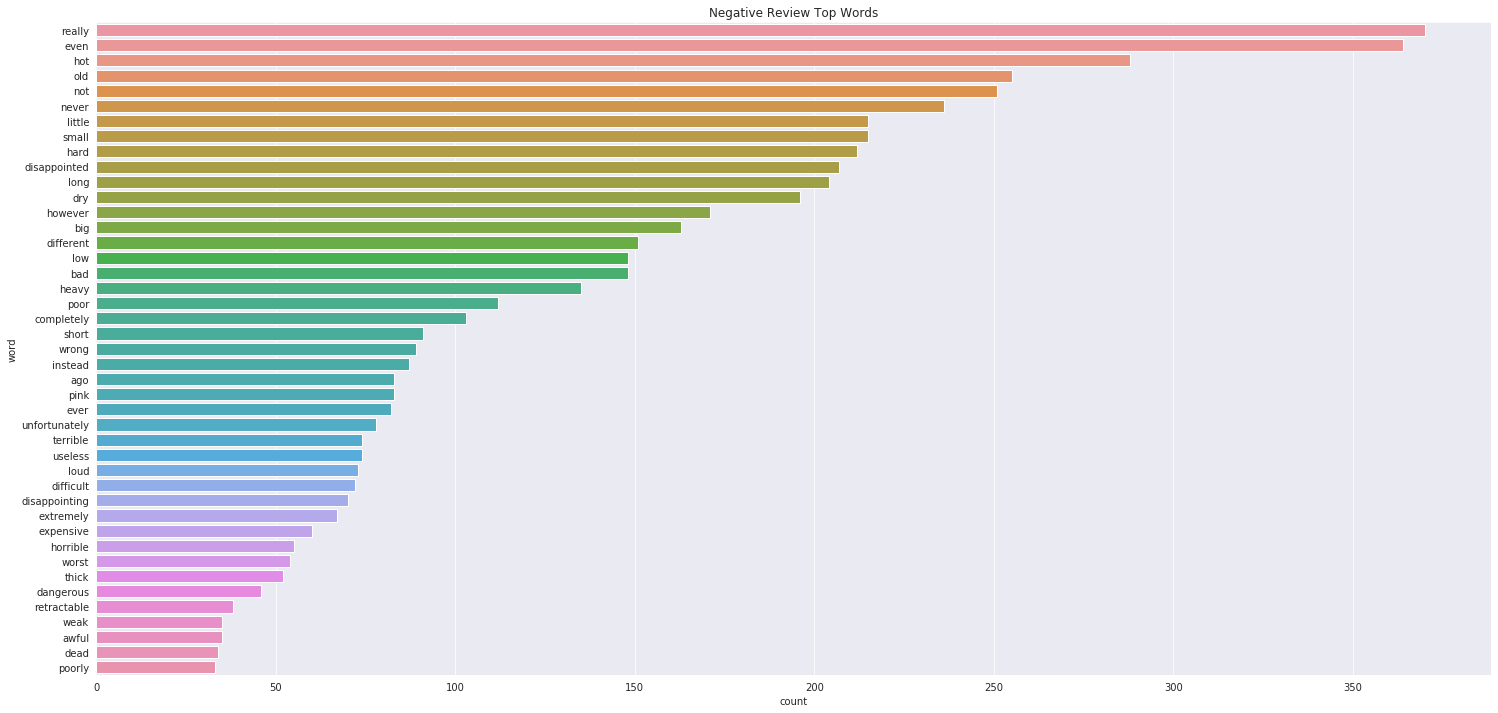

In [231]:
plt.figure(figsize=(25, 12))
sns.set_style("darkgrid")
sns.barplot(x="count",y="word", data=neg.iloc[[2,3,9,12,13,14,15,17,18,20,21,22,27,30,31,32,33,37,42,46,53,56,57,61,62,63,65,68,69,70,71,75,77,85,94,98,102,111,131,139,141,142,149],:])
plt.title("Negative Review Top Words")
plt.savefig('negative_word')

In [209]:
neg.iloc[120:150,:]

,word,count
120,totally,41
121,cold,40
122,quiet,40
123,whole,39
124,real,39
125,extra,39
126,clear,39
127,white,38
128,often,38
129,cheaper,38


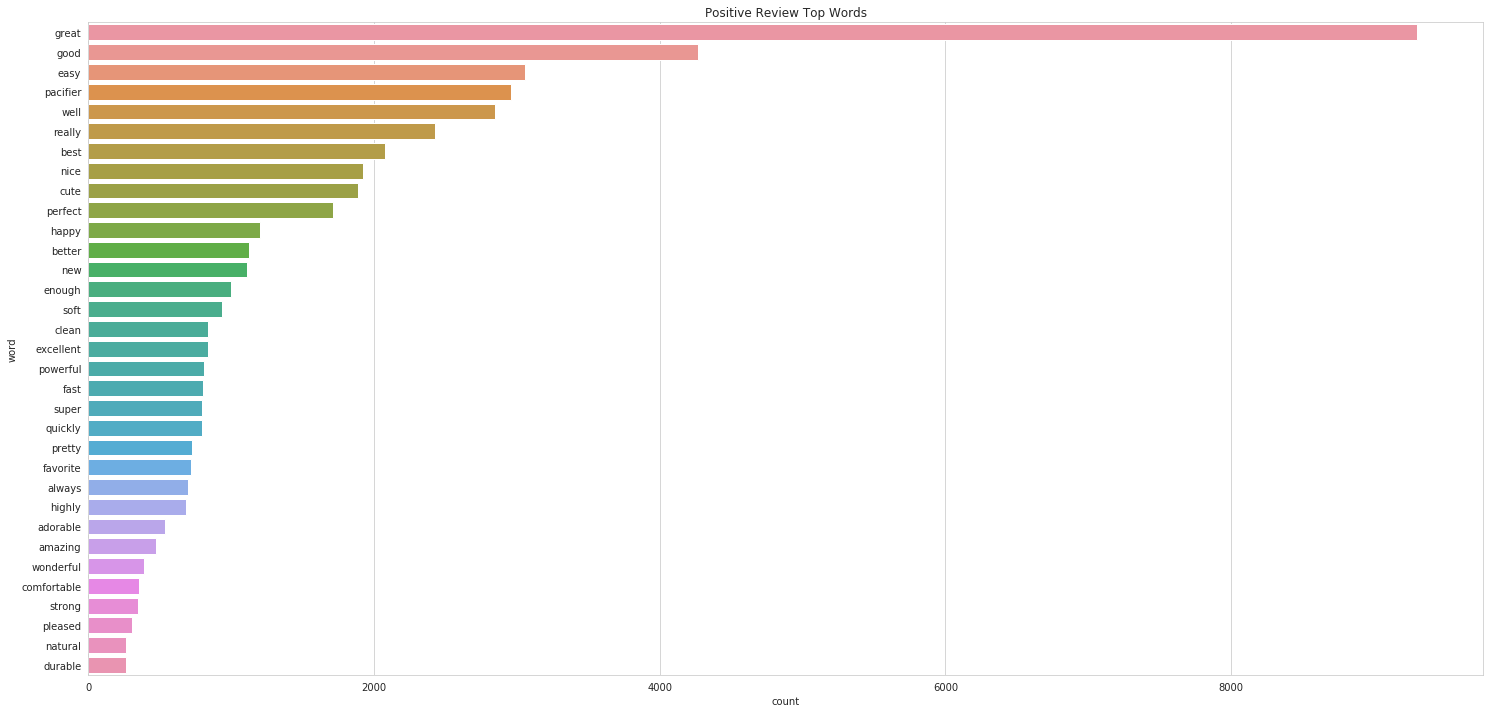

In [232]:
plt.figure(figsize=(25, 12))
sns.set_style("whitegrid")
sns.barplot(x="count",y="word", data=pos.iloc[[0,1,3,4,5,6,9,11,12,13,19,21,22,24,28,29,30,34,35,36,37,42,44,46,47,60,67,78,82,84,93,106,109],:])
plt.title("Positive Review Top Words")
plt.savefig('positive_word')